In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
def smooth(series):
    return (series[1:] + series[:-1]) / 2.

def read_results_files(postfix):
    results_folder = './results/'
    results_files = [
        'l1-fanout-qtrain',
        'l1-fanout',
        'weightscale',
        'nopenalty'
    ]
    
    coefficients = {}
    activities = {}
    accuracies = {}

    for name in results_files:
        f = np.loadtxt(os.path.join(results_folder,
                                    name + postfix + '.txt'))
        f = np.atleast_2d(f)
        coeff, act, acc = f.T
        print(f.T.shape)
        idx = np.argsort(coeff)
        coefficients[name] = coeff[idx]
        activities[name] = act[idx]
        accuracies[name] = acc[idx]
    
    return coefficients, activities, accuracies

os.makedirs("figures", exist_ok=True)

## Testing the quantized network

(3, 40)
(3, 40)
(3, 18)
(3, 1)


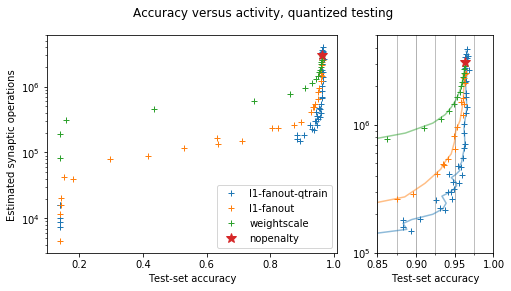

In [3]:
coefficients, activities, accuracies = read_results_files('_qtest_True')

fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [2.5, 1]})
for i, name in enumerate(coefficients.keys()): 
    if name == 'nopenalty': continue
    # First plot
    ax[0].plot(accuracies[name], activities[name], '+', label=name)
    # Second plot
    act, acc = smooth(activities[name]), smooth(accuracies[name])
    ax[1].plot(accuracies[name], activities[name], '+', label=name, c=f"C{i}")
    ax[1].plot(acc, act, alpha=0.5, c=f"C{i}")
    
# Plot nopenalty (single point)
ax[0].plot(accuracies['nopenalty'], activities['nopenalty'],
           '*', label='nopenalty', c='C3', markersize=10)
ax[1].plot(accuracies['nopenalty'], activities['nopenalty'],
           '*', c='C3', markersize=10)
    
ax[0].set_yscale('log')
ax[0].set_ylim([3e3, 6e6])
ax[0].legend(loc=4)
ax[0].set_xlabel("Test-set accuracy")
ax[0].set_ylabel("Estimated synaptic operations")

ax[1].set_yscale('log')
ax[1].set_ylim([1e5, 5e6])
ax[1].set_xlim([0.85, 1.0])
ax[1].set_xticks(np.arange(0.85, 1.0, 0.05))
ax[1].set_xticks(np.arange(0.85, 1.0, 0.025), minor=True)
ax[1].grid(axis='x', markevery=0.01, which='both')
ax[1].set_xlabel("Test-set accuracy")

# fig.tight_layout()
fig.suptitle("Accuracy versus activity, quantized testing");
fig.savefig("figures/act-acc.pdf", bbox_inches='tight')

### Analyzing the dependence on α

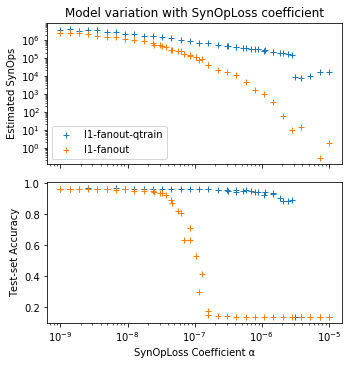

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(5,5), sharex=True)
for name in ['l1-fanout-qtrain', 'l1-fanout']:  # ignore weight scaling and nopenalty
    ax[0].plot(coefficients[name], activities[name], '+', label=name)
    ax[1].plot(coefficients[name], accuracies[name], '+')
    
ax[0].set_yscale('log')
ax[0].set_ylabel('Estimated SynOps')
ax[1].set_xlabel('SynOpLoss Coefficient α')
ax[1].set_ylabel('Test-set Accuracy')
ax[1].set_xscale('log')
ax[0].legend()

fig.tight_layout()
ax[0].set_title("Model variation with SynOpLoss coefficient")

fig.savefig("figures/alpha.pdf", bbox_inches='tight')

## Testing the non-quantized network

(3, 40)
(3, 40)
(3, 10)
(3, 1)


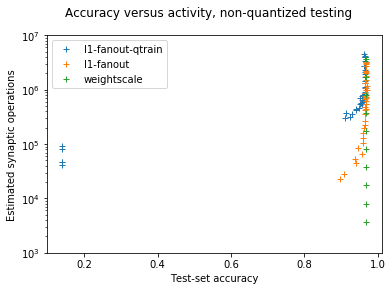

In [5]:
coefficients, activities, accuracies = read_results_files('_qtest_False')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i, name in enumerate(coefficients.keys()):  # exclude nopenalty
    if name == 'nopenalty': continue
    # First plot
    ax.plot(accuracies[name], activities[name], '+',
             label=name.split('_qtest_True')[0])
    
# # Plot nopenalty (single point)
# ax[0].plot(accuracies['nopenalty_qtest_True'],
#            activities['nopenalty_qtest_True'],
#            '*', label='nopenalty', c='C3')
# ax[1].plot(accuracies['nopenalty_qtest_True'],
#            activities['nopenalty_qtest_True'], '*', c='C3')
    
ax.set_yscale('log')
ax.set_ylim([1e3, 1e7])
ax.legend(loc=0)
ax.set_xlabel("Test-set accuracy")
ax.set_ylabel("Estimated synaptic operations")



# fig.tight_layout()
fig.suptitle("Accuracy versus activity, non-quantized testing");
fig.savefig("figures/act-acc_no_test_quant.pdf", bbox_inches='tight')

## Testing the spiking (Sinabs) network

(3, 40)
(3, 40)
(3, 18)
(3, 1)


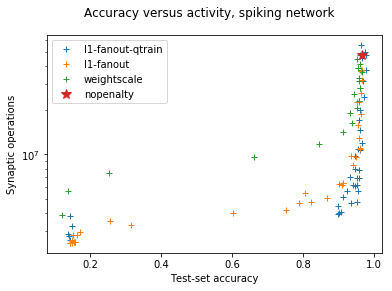

In [6]:
coefficients, activities, accuracies = read_results_files('_spiking')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i, name in enumerate(coefficients.keys()):  # exclude nopenalty
    if name == 'nopenalty': continue
    # First plot
    ax.plot(accuracies[name], activities[name], '+',
             label=name.split('_qtest_True')[0])
    
# Plot nopenalty (single point)
ax.plot(accuracies['nopenalty'], activities['nopenalty'],
        '*', label='nopenalty', c='C3', markersize=10)
    
ax.set_yscale('log')
# ax.set_ylim([1e3, 1e7])
ax.legend(loc=0)
ax.set_xlabel("Test-set accuracy")
ax.set_ylabel("Synaptic operations")



# fig.tight_layout()
fig.suptitle("Accuracy versus activity, spiking network");
fig.savefig("figures/act-acc_sinabs.pdf", bbox_inches='tight')

## Showing how the dataset is like

['frame', 'spiketrain', 'label', 'original_filename', 'bins_xy']


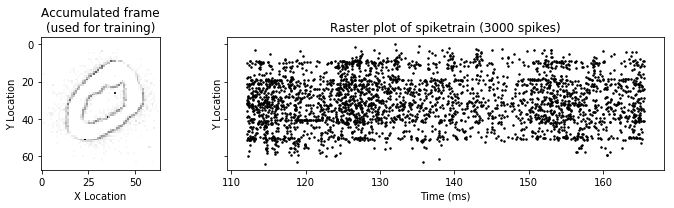

In [7]:
f = np.load('data/train/mnist_0_scale16_0001_0002.npz')

print(list(f.keys()))

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True, gridspec_kw={'width_ratios': [1, 2.]})
ax[0].imshow(f['frame'], interpolation='none', cmap=plt.cm.gray_r)

x, y, t = f['spiketrain']['x'], f['spiketrain']['y'], f['spiketrain']['t']
x_loc, y_loc = (x - x.min()) / (x.max()-x.min()), (y - y.min()) / (y.max() - y.min())
loc = x_loc + y_loc

ax[1].plot(t/1000, (1-y_loc)*64, '.k', markersize=3)

ax[0].set_ylabel("Y Location")
ax[1].set_ylabel("Y Location")
ax[1].set_xlabel("Time (ms)")
ax[0].set_xlabel("X Location")
ax[0].set_title("Accumulated frame\n(used for training)")
ax[1].set_title("Raster plot of spiketrain (3000 spikes)")

fig.tight_layout()
fig.savefig('figures/data-raster.pdf', bbox_inches='tight')

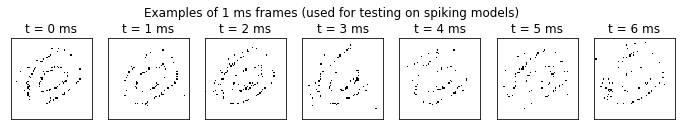

In [8]:
h = np.histogramdd((x, y, t), bins=(*f['bins_xy'], np.arange(t.min(), t.max(), 1000)))[0]

N = 7 

fig, ax = plt.subplots(1, N, figsize=(1.7*N, 2.1))

for i in range(N):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    T = i#53//N*i
    ax[i].set_title(f't = {T} ms')
    ax[i].imshow(h[:, :, T], plt.cm.gray_r, vmin=0, vmax=1)
    
fig.suptitle("Examples of 1 ms frames (used for testing on spiking models)")
fig.savefig('figures/ms-frames.pdf', bbox_inches='tight')